In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('credit_card_approval.csv')
df = df.astype({i:'category' for i in df.select_dtypes('object').columns})
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3924 entries, 0 to 3923
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   ID          3924 non-null   int64   
 1   Gender      3924 non-null   category
 2   Car         3924 non-null   category
 3   Property    3924 non-null   category
 4   Children    3924 non-null   category
 5   Income      3924 non-null   float64 
 6   Education   3924 non-null   category
 7   Family      3924 non-null   category
 8   HouseType   3924 non-null   category
 9   Birth       3924 non-null   int64   
 10  Workdays    3924 non-null   int64   
 11  WorkPhone   3924 non-null   int64   
 12  Phone       3924 non-null   int64   
 13  Email       3924 non-null   int64   
 14  Job         3924 non-null   category
 15  WorkMonths  3924 non-null   int64   
 16  Status      3924 non-null   category
 17  Risk        3924 non-null   int64   
dtypes: category(9), float64(1), int64(8)
memory usag

In [3]:
# Target Variable Analysis: Risk
pd.concat([df['Risk'].value_counts(),df['Risk'].value_counts(normalize=True)*100],axis=1,keys=['Count','Percentage']).reset_index().rename(columns={'index':'Risk'})

,Risk,Count,Percentage
0,0,1962,50.0
1,1,1962,50.0


In [4]:
# Feature Engineering
# model to understand the patterns or behaviors of individual clients, including their repeating application behavior
# One way to do this is to create a new feature, for example 'Number of Applications', which counts the number of times each client has applied. 
# This could give our model insight into the behavior of repeat applicants.
# Another way is to create a new feature, for example 'Time Since First Application', which calculates the time between each application and 
# the first application. This could give our model insight into the behavior of new applicants.


# Number of Applications
df['no_of_application'] = df.groupby('ID')['ID'].transform('count')

# Time Since First Application
df['time_since_first_application'] = df.groupby('ID')['Birth'].transform('min')  # Replace 'Birth' with appropriate column

# Insert the new features before "Risk" column
df = df.reindex(columns=['no_of_application','time_since_first_application'] + list(df.columns[:-2]))

In [5]:
df.head(2)

,no_of_application,time_since_first_application,ID,Gender,Car,Property,Children,Income,Education,Family,HouseType,Birth,Workdays,WorkPhone,Phone,Email,Job,WorkMonths,Status,Risk
0,1,11770,5113255,F,Y,Y,No children,247500.0,Secondary / secondary special,Single / not married,With parents,11770,285,0,0,0,Sales staff,2,paid off that month,0
1,1,11542,5125882,F,Y,Y,2+ children,180000.0,Higher education,Civil marriage,House / apartment,11542,1169,0,0,1,Sales staff,2,paid off that month,0


In [6]:
print(df.iloc[:,-2].describe()) # original array was 5,37,677
print(df.iloc[:,-1].describe())

count                                                  3924
unique                                                    8
top       Overdue or bad debts, write-offs for more than...
freq                                                   1087
Name: Status, dtype: object
count    3924.000000
mean        0.500000
std         0.500064
min         0.000000
25%         0.000000
50%         0.500000
75%         1.000000
max         1.000000
Name: Risk, dtype: float64


In [7]:
# feature encoding
# Import Libraries
!pip install category-encoders
from category_encoders import WOEEncoder
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

# Encoding Technique
# Selected Features 
col = ['Gender', 'Car', 'Property', 'Children', 'Education', 'Family', 'HouseType', 'Job', 'Status', 'Risk']
print("Categorical Features: ", col)
display(df[col].sample(2))

# No. of classes in a feature
data = {i: (df[i].nunique(),df[i].unique().tolist()) for i in df[col]}
print("Class Features: ", data)
print()

# Binary Class Features
_binary = [i for i,j in data.items() if j[0] == 2] 
print("Binary Features: ", _binary)

# More Classes Features
_multi = [i for i,j in data.items() if (j[0] > 2) and (i not in _binary)]
print("More Features: ", _multi)

# ========== Weightage Encoding ============= #
# Note: A high volume of datapoint is classified to one class, weightage goes to '1'.

# One Hot Encoding
data = [(i, dict([(y,x) for x,y in enumerate(df[i].value_counts().index.to_list()[::-1])])) for i in _binary]
print("Binary Class Features: ", data)

# Transformation
for index,values in data:
    df[index].replace(values, inplace=True)

# Convert the category data type features into numerical data type
df[_binary] = df[_binary].astype('int64')

# =========== Target Encoding =============== #
# Note: Based on Target feature, encoding is performed.

# WoE Encoding: PerfectSeparationError
# woe = WOEEncoder(_multi)
# _woe = woe.fit_transform(df[_multi], df['Target'].replace({'Yes':1,'No':0}))
# display("Multi Class Features: ", _woe.sample(1))
# df[_multi] = _woe

# label Encoding: LinAlgError
# le = LabelEncoder()
# for col in df[_multi].columns:
#     df[col] = le.fit_transform(df[_multi][col])

# Ordinal Encoding
oe = OrdinalEncoder()
df[_multi] = oe.fit_transform(df[_multi])

Categorical Features:  ['Gender', 'Car', 'Property', 'Children', 'Education', 'Family', 'HouseType', 'Job', 'Status', 'Risk']


,Gender,Car,Property,Children,Education,Family,HouseType,Job,Status,Risk
3801,M,Y,Y,No children,Higher education,Single / not married,House / apartment,Managers,"Overdue or bad debts, write-offs for more than...",1
364,F,N,Y,No children,Higher education,Married,House / apartment,Core staff,No loan for the month,0


Class Features:  {'Gender': (2, ['F', 'M']), 'Car': (2, ['Y', 'N']), 'Property': (2, ['Y', 'N']), 'Children': (3, ['No children', '2+ children', '1 children']), 'Education': (5, ['Secondary / secondary special', 'Higher education', 'Incomplete higher', 'Lower secondary', 'Academic degree']), 'Family': (5, ['Single / not married', 'Civil marriage', 'Married', 'Separated', 'Widow']), 'HouseType': (6, ['With parents', 'House / apartment', 'Municipal apartment', 'Office apartment', 'Rented apartment', 'Co-op apartment']), 'Job': (18, ['Sales staff', 'Managers', 'Laborers', 'Drivers', 'Core staff', 'Medicine staff', 'Security staff', 'Accountants', 'Low-skill Laborers', 'Private service staff', 'Cooking staff', 'Cleaning staff', 'Secretaries', 'Waiters/barmen staff', 'High skill tech staff', 'HR staff', 'IT staff', 'Realty agents']), 'Status': (8, ['paid off that month', '1-29 days past due', 'No loan for the month', '30-59 days past due', '60-89 days overdue', 'Overdue or bad debts, write-

In [8]:
df.head(2)

,no_of_application,time_since_first_application,ID,Gender,Car,Property,Children,Income,Education,Family,HouseType,Birth,Workdays,WorkPhone,Phone,Email,Job,WorkMonths,Status,Risk
0,1,11770,5113255,1,0,1,2.0,247500.0,4.0,3.0,5.0,11770,285,0,0,0,14.0,2,7.0,1
1,1,11542,5125882,1,0,1,1.0,180000.0,1.0,0.0,1.0,11542,1169,0,0,1,14.0,2,7.0,1


In [9]:
from desc_stats import desc_stats
desc_stats(df, df.columns)

,no_of_application,time_since_first_application,ID,Gender,Car,Property,Children,Income,Education,Family,HouseType,Birth,Workdays,WorkPhone,Phone,Email,Job,WorkMonths,Status,Risk
Mean,8.124363,15146.34633,5084946.994903,0.558104,0.552497,0.654179,1.348114,201220.329128,2.95158,1.406473,1.301988,15146.34633,2407.025994,0.302752,0.331549,0.10423,7.652396,19.582824,4.311417,0.5
Median,2.0,15212.5,5089784.0,1.0,1.0,1.0,2.0,180000.0,4.0,1.0,1.0,15212.5,1651.0,0.0,0.0,0.0,8.0,17.0,5.0,0.5
Mode,1.0,20103.0,5085886.0,1.0,1.0,1.0,2.0,135000.0,4.0,1.0,1.0,20103.0,555.0,0.0,0.0,0.0,8.0,3.0,6.0,0.0
Variance,149.757663,11565262.365623,1805647575.604358,0.246687,0.247307,0.226286,0.766881,12477444094.448809,1.932399,0.842385,0.968938,11565262.365623,5029411.095934,0.211147,0.221681,0.09339,18.378758,197.732878,6.445437,0.250064
Std,12.237551,3400.773789,42492.912063,0.496676,0.4973,0.475696,0.875718,111702.480252,1.390107,0.917815,0.984347,3400.773789,2242.634856,0.459508,0.47083,0.305598,4.287045,14.061752,2.538786,0.500064
Coef_Var,1.506278,0.224528,0.008357,0.889934,0.900094,0.727164,0.649587,0.555125,0.470971,0.652565,0.756034,0.224528,0.931704,1.517767,1.42009,2.931949,0.560223,0.718066,0.588852,1.000127
Min,1.0,7757.0,5008822.0,0.0,0.0,0.0,0.0,36000.0,0.0,0.0,0.0,7757.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Max,48.0,24449.0,5150478.0,1.0,1.0,1.0,2.0,900000.0,4.0,4.0,5.0,24449.0,14887.0,1.0,1.0,1.0,17.0,60.0,7.0,1.0
Range,47.0,16692.0,141656.0,1.0,1.0,1.0,2.0,864000.0,4.0,4.0,5.0,16692.0,14870.0,1.0,1.0,1.0,17.0,60.0,7.0,1.0
Q1,1.0,12330.0,5048273.25,0.0,0.0,0.0,0.0,126000.0,1.0,1.0,1.0,12330.0,863.0,0.0,0.0,0.0,4.0,8.0,3.0,0.0


In [10]:
# Handling Skewness using power transformation
# Import Libraries
from sklearn.preprocessing import PowerTransformer

# PowerTransformer
pt = PowerTransformer(method='yeo-johnson', standardize=True)
df.iloc[:,:-1] = pt.fit_transform(df.iloc[:,:-1])

# Handling Outliers using RobustScaler
# Import Libraries
from sklearn.preprocessing import RobustScaler

# RobustScaler
rs = RobustScaler()
df.iloc[:,:-1] = rs.fit_transform(df.iloc[:,:-1])

In [11]:
df.iloc[:,:-1]

,no_of_application,time_since_first_application,ID,Gender,Car,Property,Children,Income,Education,Family,HouseType,Birth,Workdays,WorkPhone,Phone,Email,Job,WorkMonths,Status
0,-0.338752,-0.625122,0.343713,0.0,-1.0,0.0,0.000000,0.455771,0.000000,1.894047,2.872382,-0.625122,-1.105230,0.0,0.0,0.000000,0.884419,-1.008902,0.708977
1,-0.338752,-0.668035,0.534023,0.0,-1.0,0.0,-0.627612,0.000000,-1.000000,-2.306140,0.000000,-0.668035,-0.245104,0.0,0.0,3.272689,0.884419,-1.008902,0.708977
2,-0.338752,-0.694869,-0.908022,-1.0,0.0,0.0,-1.000000,0.783071,-1.000000,0.000000,0.000000,-0.694869,-0.063386,0.0,0.0,0.000000,0.309770,-0.046580,0.708977
3,-0.338752,-0.209381,0.525319,-1.0,0.0,0.0,-0.627612,-0.199451,0.000000,0.000000,0.000000,-0.209381,0.426370,0.0,0.0,0.000000,0.000000,0.796143,-1.465951
4,-0.338752,0.608518,-0.577651,0.0,0.0,-1.0,0.000000,-1.092482,0.000000,1.152921,0.000000,0.608518,1.537248,0.0,0.0,0.000000,0.000000,0.330706,0.708977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3919,0.405077,0.276489,0.100567,0.0,0.0,0.0,0.000000,0.000000,-0.434267,2.428626,0.000000,0.276489,0.224874,1.0,1.0,0.000000,-1.327609,0.673678,-1.224735
3920,0.000000,-0.178171,0.093884,-1.0,-1.0,-1.0,0.000000,-0.436066,0.000000,0.000000,0.000000,-0.178171,-1.630642,0.0,0.0,0.000000,1.154617,0.641923,-0.651810
3921,-0.338752,-0.498169,-0.884899,-1.0,0.0,0.0,0.000000,0.322237,0.000000,-2.306140,0.000000,-0.498169,-0.002219,0.0,0.0,0.000000,0.884419,-1.008902,-0.651810
3922,0.000000,0.465893,-0.514873,-1.0,-1.0,0.0,0.000000,0.322237,0.000000,0.000000,0.000000,0.465893,0.555361,0.0,0.0,0.000000,-0.690230,0.509718,-0.651810


In [12]:
desc_stats(df, df.columns)

,no_of_application,time_since_first_application,ID,Gender,Car,Property,Children,Income,Education,Family,HouseType,Birth,Workdays,WorkPhone,Phone,Email,Job,WorkMonths,Status,Risk
Mean,0.117203,-0.028901,-0.04863,-0.441896,-0.447503,-0.345821,-0.340252,-0.050922,-0.355214,0.311566,0.206735,-0.028901,0.016851,0.302752,0.331549,0.341114,-0.112304,-0.019011,-0.173613,0.5
Median,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5
Mode,-0.338752,0.830221,-0.055843,0.0,0.0,0.0,0.0,-0.436066,0.0,0.0,0.0,0.830221,-0.725767,0.0,0.0,0.0,0.0,-0.897235,0.34819,0.0
Variance,0.243537,0.362952,0.365666,0.246687,0.247307,0.226286,0.198325,0.509149,0.217609,1.000255,1.000255,0.362952,0.526078,0.211147,0.221681,1.000255,0.510943,0.422754,0.626934,0.250064
Std,0.493495,0.602455,0.604704,0.496676,0.4973,0.475696,0.445336,0.713547,0.466486,1.000127,1.000127,0.602455,0.725312,0.459508,0.47083,1.000127,0.714803,0.650196,0.791792,0.500064
Coef_Var,4.210603,-20.845344,-12.434718,-1.123965,-1.111278,-1.375556,-1.308843,-14.012503,-1.313254,3.210003,4.837719,-20.845344,43.043176,1.517767,1.42009,2.931949,-6.364899,-34.201185,-4.560658,1.000127
Min,-0.338752,-1.416508,-1.090805,-1.0,-1.0,-1.0,-1.0,-2.775558,-1.135684,-2.30614,-5.28001,-1.416508,-2.284186,0.0,0.0,0.0,-1.597876,-1.322313,-1.465951,0.0
Max,0.928086,1.525886,0.915879,0.0,0.0,0.0,0.0,2.045734,0.0,2.428626,2.872382,1.525886,1.964747,1.0,1.0,3.272689,1.286224,1.350481,0.708977,1.0
Range,1.266839,2.942394,2.006683,1.0,1.0,1.0,1.0,4.821291,1.135684,4.734766,8.152392,2.942394,4.248933,1.0,1.0,3.272689,2.884101,2.672794,2.174928,1.0
Q1,-0.338752,-0.520596,-0.577084,-1.0,-1.0,-1.0,-1.0,-0.544229,-1.0,0.0,0.0,-0.520596,-0.448589,0.0,0.0,0.0,-0.69023,-0.490282,-0.65181,0.0


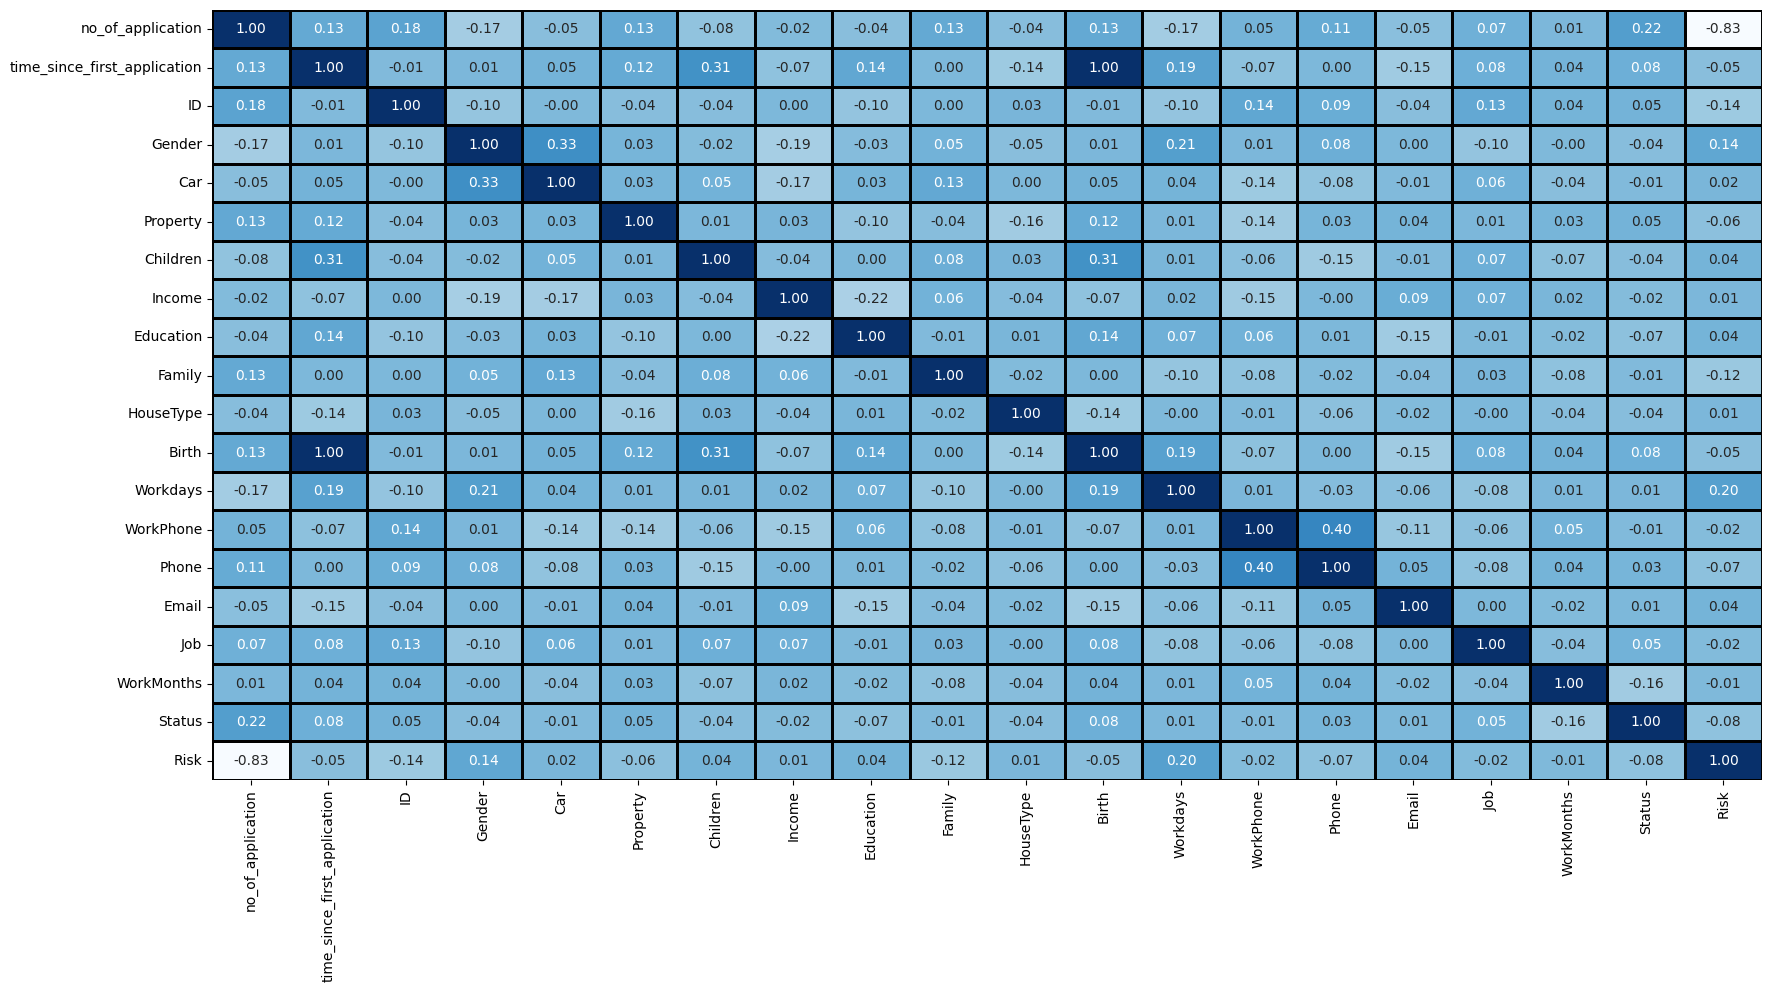

In [13]:
plt.figure(figsize=(20,10))
sns.heatmap(df.corr(), annot=True, cmap='Blues', fmt='.2f', linewidths=2, linecolor='black', cbar=False)
plt.show()

# Feature Elimination  
df.drop(['ID', 'Birth'], axis=1, inplace=True)


In [14]:
# train test split
# Import Libraries
from sklearn.model_selection import train_test_split

# Splitting the dataset into train and test
X = df.drop('Risk', axis=1)
y = df['Risk']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=df['Risk'])

print(y_train.value_counts(normalize=True)*100)
print(y_test.value_counts(normalize=True)*100)

# Forward-Selection Features : ['Workdays', 'ID', 'Status', 'Family', 'Gender', 'Birth', 'Children', 'Property', 'Phone', 'Email']

Risk
1    50.015929
0    49.984071
Name: proportion, dtype: float64
Risk
0    50.063694
1    49.936306
Name: proportion, dtype: float64


In [15]:
# Model Building
# Import Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
import statsmodels.api as sm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_score, recall_score, f1_score

In [16]:
performance_df = pd.DataFrame(columns=['Model Name', 'Train Accuracy', 'Train F1 score',
                                       'Test Accuracy', 'Test F1 Score', 'AUC Score', 'Remarks'], index=range(0))


def perf(model, name):
    global performance_df
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    pred_prob = model.predict_proba(X_test)[:, 1]

    train_acc = accuracy_score(y_train, pred_train)
    test_acc = accuracy_score(y_test, pred_test)
    train_f1 = f1_score(y_train, pred_train)
    test_f1 = f1_score(y_test, pred_test)

    remarks = 'Overfit' if abs(train_acc - test_acc) > 0.02 or train_acc > 0.95 else \
        'Underfit' if train_acc < 0.80 or test_acc < 0.80 else 'Good Fit'

    auc_score = round(roc_auc_score(y_test, pred_test), 4)
    performance_df.loc[len(performance_df)] = [name, train_acc, train_f1, test_acc, test_f1, auc_score, remarks]

    # plotting roc_curve and calculating auc_score
    fpr, tpr, threshold = roc_curve(y_test, pred_prob)

    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr)
    plt.plot([0.0, 1.0], 'r--')
    plt.text(x=0.1, y=1.0, s=('auc_score', auc_score))

    print(classification_report(y_test, pred_test))

In [17]:
# MLE Model 
lr = sm.Logit(y_train, sm.add_constant(X_train)).fit()
print(lr.summary())

odds = pd.DataFrame(np.exp(lr.params), columns = ['ODDS'])
odds = odds.T
odds

Optimization terminated successfully.
         Current function value: 0.227152
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                   Risk   No. Observations:                 3139
Model:                          Logit   Df Residuals:                     3121
Method:                           MLE   Df Model:                           17
Date:                Wed, 07 Jun 2023   Pseudo R-squ.:                  0.6723
Time:                        13:10:36   Log-Likelihood:                -713.03
converged:                       True   LL-Null:                       -2175.8
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           -0.0299      0.165     -0.181      0.856

,const,no_of_application,time_since_first_application,Gender,Car,Property,Children,Income,Education,Family,HouseType,Workdays,WorkPhone,Phone,Email,Job,WorkMonths,Status
ODDS,0.970501,0.000555,1.222068,1.297756,0.686871,1.159907,0.643489,1.063098,0.968276,0.947144,0.967254,1.572809,1.079495,1.121926,1.143476,1.280042,1.064033,1.75388


              precision    recall  f1-score   support

           0       0.93      0.94      0.94       393
           1       0.94      0.93      0.94       392

    accuracy                           0.94       785
   macro avg       0.94      0.94      0.94       785
weighted avg       0.94      0.94      0.94       785



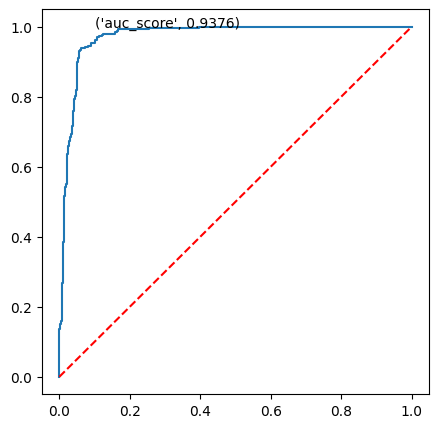

In [18]:
# Logistic regression model after scaling
model_log = LogisticRegression().fit(X_train,y_train)
perf(model_log,'Logistic Regression')

In [19]:
performance_df

,Model Name,Train Accuracy,Train F1 score,Test Accuracy,Test F1 Score,AUC Score,Remarks
0,Logistic Regression,0.922905,0.925124,0.93758,0.93726,0.9376,Good Fit
